# 加载数据集

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import pickle
import math
import random
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['diagnosis'] = cancer.target
df.loc[df.diagnosis==0,'diagnosis'] = -1
df.loc[df.diagnosis==1,'diagnosis'] = 0
df.loc[df.diagnosis==-1,'diagnosis'] = 1
df.to_csv("cancer.csv", index=False)

# isolation forist 用于异常检测

fit time 0.03s
score time 0.01s
Computed 0.8000 TPR threshold 0.4830 with FPR 0.0616
Proportion anomalies/normal = 212/357 = 59.4%
F1 score 0.7717, avg PR 0.8669


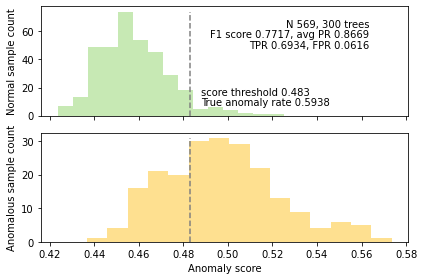

In [2]:
import numpy as np
import itertools
import bisect
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
import time
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, \
    confusion_matrix, f1_score, average_precision_score
from iforest import IsolationTreeEnsemble, find_TPR_threshold
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

# def add_noise(df, n_noise):
#     for i in range(n_noise):
#         df[f'noise_{i}'] = np.random.normal(-2,2,len(df))


def plot_anomalies(X, y, sample_size=256, n_trees = 100, desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)
    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    print(f"fit time {fit_time:3.2f}s")
    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
    print(f"score time {score_time:3.2f}s")
    if desired_TPR is not None:
        threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)
        print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    confusion = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]
    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)
    print(f"Proportion anomalies/normal = {len(anomalies)}/{len(normal)} = {(len(anomalies)/len(normal))*100:.1f}%")
    print(f"F1 score {F1:.4f}, avg PR {PR:.4f}")
    fig, axes = plt.subplots(2, 1, sharex=True)
    counts0, binlocs0, _ = axes[0].hist(normal, color='#c7e9b4', bins=bins)
    counts1, binlocs1, _ = axes[1].hist(anomalies, color='#fee090', bins=bins)
    axes[1].set_xlabel("Anomaly score")
    axes[0].set_ylabel("Normal sample count")
    axes[1].set_ylabel("Anomalous sample count")
    axes[0].plot([threshold,threshold],[0,max(counts0)], '--', color='grey')
    axes[1].plot([threshold,threshold],[0,max(counts1)], '--', color='grey')
    text_xr = 0.97 * axes[0].get_xlim()[1]
    axes[0].text(text_xr, .85 * max(counts0), f"N {N}, {n_trees} trees", horizontalalignment='right')
    axes[0].text(text_xr, .75 * max(counts0), f"F1 score {F1:.4f}, avg PR {PR:.4f}", horizontalalignment='right')
    axes[0].text(text_xr, .65 * max(counts0), f"TPR {TPR:.4f}, FPR {FPR:.4f}", horizontalalignment='right')
    axes[0].text(threshold+.005, .20 * max(counts0), f"score threshold {threshold:.3f}")
    axes[0].text(threshold+.005, .10 * max(counts0), f"True anomaly rate {len(anomalies) / len(normal):.4f}")
    if normal_ymax is not None:
        axes[0].set_ylim(0, normal_ymax)
    plt.tight_layout()
    plt.savefig(f"{datafile.split('.')[0]}-{n_trees}-{int(desired_TPR*100)}.svg",
                bbox_inches='tight',
                pad_inches=0)

    return F1
if __name__ == '__main__': # dask seems to need this

    datafile = 'cancer.csv'

    targetcol = 'diagnosis'
    sample_size = int(5)
    n_trees = int(300)
    desired_TPR = int(80)
    desired_TPR /= 100.0

    X, y = df.drop(targetcol, axis=1), df[targetcol]

    plot_anomalies(X, y, sample_size=sample_size, n_trees=n_trees, desired_TPR=desired_TPR, bins=15)

# 对特征相关性作图

In [3]:
import random 
X_ , Y_ = df.drop(targetcol, axis=1), df[targetcol]
A_X = np.array(X_)
A_Y = np.array(Y_)
data = np.c_[A_X,A_Y]
data_nor = data[np.where(data[:,-1]==0)]
data_ano = data[np.where(data[:,-1]==1)]


# 分层聚类算法对特征分类

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# mpl.rcParams['font.sans-serif'] = ['SimHei']
N=len(A_X) #569
M=len(A_X[0])#30


fft_X = np.zeros([N,M])
fft_X_std = np.zeros(M)
for i in range(M):
    fft_X[:,i] = np.abs(fft(A_X[:,i]))/N
#     fft_X_std[i] = np.std(fft_X[:,i]) 
    fft_X_std[i] = np.mean(fft_X[:,i]) 



Matrix_dis = np.zeros([M,M])
for i in range(M):
    for j in range(M):
        if i == j:
            continue 
        Matrix_dis[i,j] = np.abs(fft_X_std[j]-fft_X_std[i])
#         Matrix_dis[i,j] = coe_sim(fft_X[:,j],fft_X[:,i])
    
clustering = AgglomerativeClustering(n_clusters=6,connectivity=None,linkage='single')
clustering = clustering.fit(Matrix_dis)


# clustering = clustering.fit(A_X.T[])

clust_lable = clustering.fit_predict(Matrix_dis) ##输出特征类别标签
print('lables of features:',clust_lable)



lables of features: [0 0 4 5 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0]


In [5]:
Matrix_dis

array([[0.00000000e+00, 3.24166178e-02, 9.11460423e-01, 1.41344168e+01,
        1.55162809e-01, 1.53748133e-01, 1.52744010e-01, 1.54320905e-01,
        1.54519833e-01, 1.55479931e-01, 1.44832010e-01, 1.33384285e-01,
        7.56106811e-02, 1.61184682e+00, 1.55724977e-01, 1.55142340e-01,
        1.54661331e-01, 1.55598950e-01, 1.55507810e-01, 1.55743233e-01,
        5.25133039e-02, 1.12918719e-01, 1.28095918e+00, 2.26257620e+01,
        1.54773058e-01, 1.49735300e-01, 1.47846962e-01, 1.53241408e-01,
        1.53056547e-01, 1.55044696e-01],
       [3.24166178e-02, 0.00000000e+00, 8.79043805e-01, 1.41020002e+01,
        1.87579427e-01, 1.86164750e-01, 1.85160628e-01, 1.86737523e-01,
        1.86936451e-01, 1.87896549e-01, 1.77248628e-01, 1.65800903e-01,
        1.08027299e-01, 1.57943020e+00, 1.88141595e-01, 1.87558957e-01,
        1.87077949e-01, 1.88015568e-01, 1.87924427e-01, 1.88159851e-01,
        2.00966862e-02, 8.05021013e-02, 1.24854256e+00, 2.25933454e+01,
        1.87189676e-01,

In [6]:
#约束聚类

from k_means_constrained import KMeansConstrained
clustering2=KMeansConstrained(n_clusters=5, size_min=6, size_max=29, random_state=0)
clustering2=clustering2.fit_predict(Matrix_dis)


print("clustering2:",clustering2)

clustering2: [4 4 1 1 2 0 0 3 3 2 4 4 4 1 2 3 3 2 2 2 4 1 1 1 3 0 0 0 0 3]


In [7]:
import numpy as np

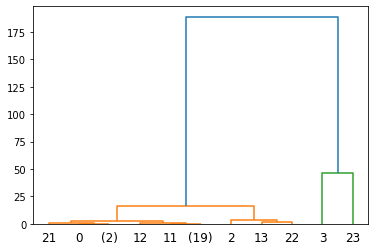

In [8]:
# 分类树状图
Clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
Clustering = Clustering.fit(Matrix_dis)
plot_dendrogram(Clustering, truncate_mode='level', p=4)

# 计算2层shap

In [9]:
def calculatShapley(cFunction,coalition,nPlayer):
    coalition=list(coalition)
    for i in range(0,len(coalition)):
        coalition[i]=list(coalition[i])

    stat = time.time()
#     print("start calculate shapley:")
    shapley_values = []
    for i in range(len(nPlayer)):
        shapley = 0
        for j in coalition:
            if i not in j:
                j=list(j)
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = coalition.index(j)
                k = coalition.index(Cui)
                temp = float(float(cFunction[k]) - float(cFunction[l])) *\
                           float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
                shapley += temp
                # if i is 0:
                #     print j, Cui, cmod, n-cmod-1, characteristic_function[k], characteristic_function[l], math.factorial(cmod), math.factorial(n - cmod - 1), math.factorial(n)

        cmod = 0
        Cui = [i]
        k = coalition.index(Cui)
        temp = float(cFunction[k]) * float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
        shapley += temp

        shapley_values.append(shapley)
    end_time = time.time()
    T_time = end_time-stat
#     print(f"time {time_cacul:3.2f}s")
    return (shapley_values)



def getcoaltionlist(n):
    coalition=[]
    singles = tuple([i for i in range(n)])
    for i in range(1, n+1):
        for p in itertools.combinations(singles, i):
            coalition.append(p)
            # if i==2:
            #     print(p)
    return coalition

def ApproShap(ListOfSampling,characteristicF,playerList,counter):
    sha=[0 for i in range(len(playerList))]
    for ob in ListOfSampling:
        k=0
        for i in ob:# ob is sequence of player id from 0 to N
            pre_i_ob=calculatePre_i(ob,i)#calculate pre^i(ob)
#             print("k",k)
            x_ob=calculateX(pre_i_ob,i,characteristicF[k])
            sha[i]=sha[i]+x_ob
        k=k+1

    sha=[x/np.shape(ListOfSampling)[0] for x in sha]
    return sha

def randomChose(probability,listPlayer):
    np.random.seed(0)
    p = np.array()
    for k in list:
        np.append(p,probability,axis=0)
    index = np.random.choice(listPlayer, p=p.ravel())
    return listPlayer[index]

def permutation(list,count): #probability: 1/n!, count: sampling size
    sampling=[]
    for k in range(0,count):
        templist = list.copy()
        random.shuffle(list)
        sampling.append(templist)
    return sampling



def calculatePre_i(ob,i):
    result=[]
    for k in range(0,len(ob)):
        if ob[k]!=i:
            result.append(ob[k])
        else :
            break

    return result

def calculateX(ob,i,characteristicF):
    new_ob=ob.copy()
    new_ob.append(i)
   # print("new_ob,",new_ob)
   # print("ob",ob)
    result = characteristicFunction(new_ob,characteristicF)-characteristicFunction(ob,characteristicF)
    return result

def characteristicFunction(ob,characteristicF):
    result=0
    #print("ob",ob)
    if ob==None:
        return result
    else:
        result=characteristicF[len(ob)-1]
    return result



In [10]:
def pr_anomalies(X, y, sample_size=256, n_trees = 100, desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)
    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
#     print(y, scores, desired_TPR)
    if desired_TPR is not None:
        try:
            threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)
        #print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
        except:
            print(y, scores, desired_TPR)
            print(type(y), type(scores), type(desired_TPR))
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    confusion = confusion_matrix(y, y_pred)

    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]

    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)

    return PR


def calculatShapley(cFunction,coalition,nPlayer):
    coalition=list(coalition)
    for i in range(0,len(coalition)):
        coalition[i]=list(coalition[i])

    stat = time.time()
    shapley_values = []
    for i in range(len(nPlayer)):
        shapley = 0
        for j in coalition:
            if i not in j:
                j=list(j)
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = coalition.index(j)
                k = coalition.index(Cui)
                temp = float(float(cFunction[k]) - float(cFunction[l])) *\
                           float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
                shapley += temp
        cmod = 0
        Cui = [i]
        k = coalition.index(Cui)
        temp = float(cFunction[k]) * float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
        shapley += temp

        shapley_values.append(shapley)
    end_time = time.time()
    T_time = end_time-stat
    return (shapley_values)

def getcoaltionlist(n):
    coalition=[]
    singles = tuple([i for i in range(n)])
    for i in range(1, n+1):
        for p in itertools.combinations(singles, i):
            coalition.append(p)
    return coalition

def getgroup_level(X,group):
    X_n = np.array(X)
    X_n = X_n
#     X_n = X_n[:,group.extend([0]*len(X) - 3)]
    X_n = X_n[:,group]
    return X_n

    
    return X_n

def shap_2level(X_n, idx_dic,player_2level):
    Phi_2Level = []
    coalition_2level = getcoaltionlist(number_group)
    for pair in coalition_2level:
        idx = [i for i in pair]
        idx_2=[]
        for j in idx:
            idx_2.extend(idx_dic[j])
        idx_2 = np.array(idx_2).reshape(-1,)
        x_selected = X_n[:,idx_2]
        pr = pr_anomalies(x_selected,y,n_trees=n_trees,desired_TPR=desired_TPR)
        Phi_2Level.append(pr)
    Shap_2level = calculatShapley(Phi_2Level,coalition_2level,player_2level)
    return Shap_2level 

def get_Phi_coalition(idx_dic):
    coalition_={}
    X, y = df.drop(targetcol, axis=1), df[targetcol]
    Phi_1level = {}
    #     idx_map = {v: k for k,v in enumerate(l1_group)}
    start_time = time.time()
    for i in range(number_group):
        coalition_[i] = getcoaltionlist(len(idx_dic[i]))
        l1_group = idx_dic[i]
        df_list2=np.array(X)
        Tm1 = df_list2[:,0:30].copy()
        Phi_=[]
        c = Tm1.copy()
    #     print(c.shape)
        for k in range(0,len(coalition_[i])):
            pl_1level = c.copy()
            diff_2 = set(l1_group) ^ set(coalition_[i][k])
    #         print(diff)
    #         diff_2=[idx_map[x] for x in diff]
#             print(diff_2)
            if (len(diff_2) != 0):
                pl_1level[:,list(diff_2)] = np.zeros(np.shape(pl_1level[:, list(diff_2)]))
#                 print("k",k)
                pr = pr_anomalies(pl_1level,y,n_trees=n_trees,desired_TPR=desired_TPR)
            else:
                pr = pr_anomalies(c,y,n_trees=n_trees,desired_TPR=desired_TPR)   
            Phi_ .append(pr)
        Phi_1level[i]=Phi_
    return Phi_1level
def ApproShap_shou(ListOfSampling,characteristicF,playerList,counter):
    sha=[0 for i in range(len(playerList))]
    shaOld=[0 for i in range(len(playerList))]
    errors=[]
    for ob in ListOfSampling:
        k=0
        shaNew=[0 for i in range(len(playerList))]
        for i in ob:# ob is sequence of player id from 0 to N
            pre_i_ob=calculatePre_i(ob,i)#calculate pre^i(ob)
#             print("k",k)
            x_ob=calculateX(pre_i_ob,i,characteristicF[k])
            sha[i]=sha[i]+x_ob
            shaNew[i]=x_ob
            print("::",shaNew)
        k=k+1
        
        tempError=0
        for i in range(0,len(shaNew)):
            tempError= tempError+ np.sqrt(shaNew[i]-shaOld[i])
        print("!!!!",tempError)
        errors.append(tempError)
        shaOld=shaNew.copy()
    sha=[x/np.shape(ListOfSampling)[0] for x in sha]
    return errors

In [11]:
#手动分组
X, y = df.drop(targetcol, axis=1), df[targetcol]
X_ = np.array(X)
number_group = 3
idx_dic = {0: [0,1,2,6,7,8,9], 1: [10,3,5,11,12,13,14,15,16,17,18,19], 2: [4,20,21,22,23,24,25,26,27,28,29]}
#Shap_2level = shap_2level(X_,idx_dic,[0,1,2])


# 计算1层shap

In [12]:
#约束聚类
from k_means_constrained import KMeansConstrained
n_clusters=5

clustering2=KMeansConstrained(n_clusters=n_clusters, size_min=6, size_max=29, random_state=0)
clustering2=clustering2.fit_predict(Matrix_dis)
print("clustering2:",clustering2)

#手动：
print(idx_dic)
a=[]
for i in range(0,n_clusters):
    print(np.where(clustering2==i))

clustering2: [4 4 1 1 2 0 0 3 3 2 4 4 4 1 2 3 3 2 2 2 4 1 1 1 3 0 0 0 0 3]
{0: [0, 1, 2, 6, 7, 8, 9], 1: [10, 3, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19], 2: [4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}
(array([ 5,  6, 25, 26, 27, 28], dtype=int64),)
(array([ 2,  3, 13, 21, 22, 23], dtype=int64),)
(array([ 4,  9, 14, 17, 18, 19], dtype=int64),)
(array([ 7,  8, 15, 16, 24, 29], dtype=int64),)
(array([ 0,  1, 10, 11, 12, 20], dtype=int64),)


In [13]:
#根据聚类计算-> 第一层沙普利
X, y = df.drop(targetcol, axis=1), df[targetcol]
X_ = np.array(X)
number_group = n_clusters
idx_dic = {0: [ 5,  6, 25, 26, 27, 28], 1: [ 2,  3, 13, 21, 22, 23], 2: [ 4, 9, 14, 17, 18, 19], 3:[ 7,  8, 15, 16, 24, 29], 4:[ 0,  1, 10, 11, 12, 20]}
Shap_2level = shap_2level(X_,idx_dic,[0,1,2,3,4])
print(Shap_2level)



[0.1546535060822152, 0.2210887631972856, 0.0244323509004382, 0.09193230227461183, 0.15389615460319434]


In [14]:
start_time = time.time()
Phi_1level_dic = get_Phi_coalition(idx_dic)
stop_time = time.time()
time_cacul = stop_time - start_time
print(f"time {time_cacul:3.2f}s")


time 118.85s


In [15]:
#第二层+乘积
coalition_1 = {}
Shap_1Level_ary = {}
Shap_ary = {}
Su = 0
for i in range(number_group):
    coalition_1[i] = getcoaltionlist(len(idx_dic[i]))
    #print(idx_dic[i])
    S_ = np.array(calculatShapley(Phi_1level_dic[i],coalition_1[i],idx_dic[i]))
    #print("分组里：",S_)
    Shap_1Level_ary[i] = S_*Shap_2level[i]
    #print(Shap_2level[i])
    Su = Su + sum(Shap_1Level_ary[i])
for i in range (number_group):
    Shap_ary[i] = Shap_1Level_ary[i]/Su
print(Shap_ary)







{0: array([0.03378982, 0.04561195, 0.03642536, 0.03008987, 0.04003155,
       0.0434838 ]), 1: array([0.04888112, 0.05417372, 0.06727582, 0.05981817, 0.06080596,
       0.0495898 ]), 2: array([0.00733899, 0.00784351, 0.0067015 , 0.00718817, 0.00667414,
       0.00677562]), 3: array([0.02574869, 0.02930248, 0.02765594, 0.02730786, 0.02357333,
       0.02605363]), 4: array([0.04581154, 0.03498386, 0.03598857, 0.02965024, 0.0443802 ,
       0.03704478])}


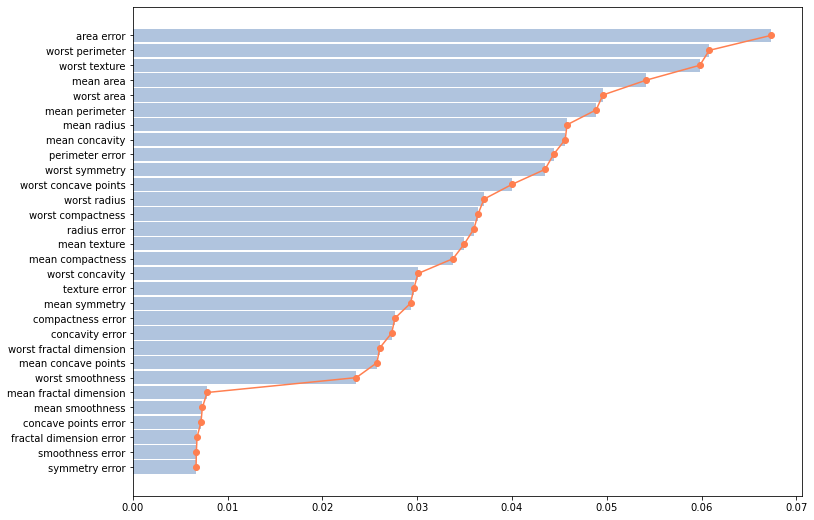

In [16]:
#对分层法进行画图

PP={0:'mean radius', 1:'mean texture', 2:'mean perimeter',3:'mean area',\
            4:'mean smoothness', 5:'mean compactness',6:'mean concavity',7:'mean concave points',\
            8:'mean symmetry',9:'mean fractal dimension',10:'radius error',\
            11:'texture error',12:'perimeter error',13:'area error',14:'smoothness error',15:'compactness error',\
            16:'concavity error',17:'concave points error',18:'symmetry error',19:'fractal dimension error',20:'worst radius',\
            21:'worst texture',22:'worst perimeter',23:'worst area',24:'worst smoothness',25:'worst compactness',\
            26:'worst concavity',27:'worst concave points',28:'worst symmetry',29:'worst fractal dimension'}
plt.figure(figsize=(12,9))
playerlist=[]
Shap_ary_plt=[]
for i in range (len(idx_dic)):
    for j in range(len(idx_dic[i])):
        Shap_ary_plt.append(np.array(Shap_ary[i][j]))
        playerlist.append(PP[idx_dic[i][j]])
Shapley=Shap_ary_plt
df = pd.DataFrame({'eventlist':playerlist, 'shapleys': Shapley})
df=df.sort_values(by=['shapleys'], axis=0, ascending=[True])
# #shapleys = [0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404]
# # plt.bar(shapleys,range(len(eventlist)), color='lightsteelblue')

plt.bar(x=0, bottom=np.arange(len(df['shapleys'])), height=0.9, width=df['shapleys'], orientation="horizontal",color='lightsteelblue')
plt.plot(df['shapleys'],range(len(df['eventlist'])), marker='o', color='coral')  # coral
plt.yticks(range(len(df['eventlist'])), df['eventlist'])
plt.savefig('Shap_bilevel_30.png')






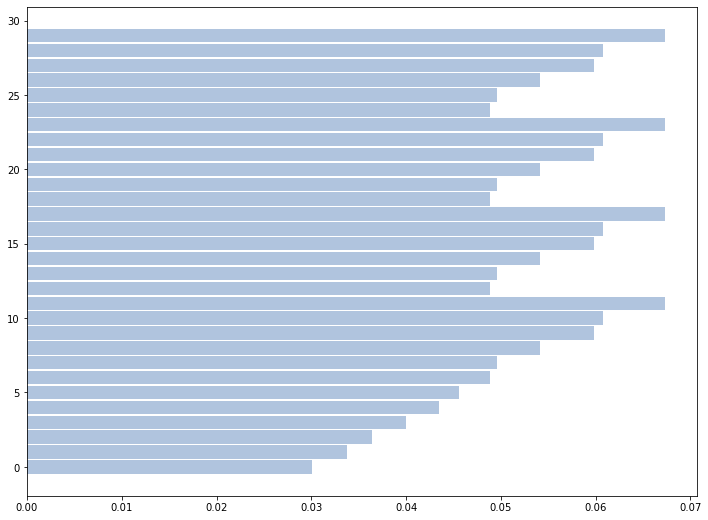

In [17]:
PP={0:'mean radius', 1:'mean texture', 2:'mean perimeter',3:'mean area',\
            4:'mean smoothness', 5:'mean compactness',6:'mean concavity',7:'mean concave points',\
            8:'mean symmetry',9:'mean fractal dimension',10:'radius error',\
            11:'texture error',12:'perimeter error',13:'area error',14:'smoothness error',15:'compactness error',\
            16:'concavity error',17:'concave points error',18:'symmetry error',19:'fractal dimension error',20:'worst radius',\
            21:'worst texture',22:'worst perimeter',23:'worst area',24:'worst smoothness',25:'worst compactness',\
            26:'worst concavity',27:'worst concave points',28:'worst symmetry',29:'worst fractal dimension'}
plt.figure(figsize=(12,9))
playerlist=[]
Shap_ary_plt=[]
for i in range (len(idx_dic)):
    for j in range(len(idx_dic[i])):
        Shap_ary_plt.append(np.array(Shap_ary[i][j]))
        playerlist.append(PP[idx_dic[i][j]])
    Shapley=Shap_ary_plt
    df = pd.DataFrame({'eventlist':playerlist, 'shapleys': Shapley})
    df=df.sort_values(by=['shapleys'], axis=0, ascending=[True])
    plt.bar(x=0, bottom=np.arange(len(df['shapleys'])), height=0.9, width=df['shapleys'], orientation="horizontal",color='lightsteelblue')



# 采样法算shap

In [18]:
%%time
playerList = []
for i in range(30):
    playerList.append(i)
counter=15    #sampling size
# characteristicF =[np.zeros(len(playerList))]*counter
            #initial table for characteristic function of coalition in permutation
samplist=[]
start_time = time.time()
characteristicF=[]
P = []
ob=playerList
rep = {}
listOfSampling=permutation(ob,counter)
#print(listOfSampling)
for i in range(counter):
    for j in range(30):
#         if j == 0:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][0])
#             size_zeros = 29
#         else:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][:j])
#             size_zeros =30 - data_samp_x.shape[1]
#         data_samp = np.c_[data_samp_x,np.zeros((569,size_zeros))]
# #         print(np.shape(data_samp))
        X_copy=X_.copy()
        X_copy[:,j+1:30]=np.zeros((569,29-j))

        pr = pr_anomalies(X_copy,y,n_trees=n_trees,desired_TPR=0.8)
        P.append(pr)
       # print("characteristic function:",j,P,X_copy,)
    rep[i] = P
    #print(rep)
RP = np.array(P)
characteristicF = RP.reshape((counter,30))
#     print(i)

sha=ApproShap(listOfSampling,characteristicF,playerList,counter)
time_cacul = stop_time - start_time
print(f"time {time_cacul:3.2f}s")
print("shapley",sha)



time -0.59s
shapley [0.009498950408023073, -0.0022501660835812175, 0.013633531096987513, 0.00548789886841999, 0.002034936955012349, 0.007930115883478769, 0.01399585671526602, -0.015995800979431037, -0.01458792233106243, 0.022177511200274683, 0.0010367545402854377, 0.001538787481335054, 0.007303904337627317, 0.005926619117051087, 0.015234628668171624, -0.013196065310747388, 0.013202814844407018, -0.030138999757585227, -0.004520268482004153, -0.017665538987144506, 0.00927377690331656, 0.002813988166429023, 0.010005370038179806, -0.03492767409166276, -0.005682154736662678, 0.017608639550816915, 0.00107584128762294, -0.021653876995912775, -0.02542658508461063, 0.026265126777699623]
Wall time: 2min 40s


# 收敛图

In [19]:
%%time
from sklearn.metrics import mean_squared_error 
# mse = mean_squared_error(A, B)
def ApproShap_shou(ListOfSampling,characteristicF,playerList,counter):
    sha=[0 for i in range(len(playerList))]
    shaOld=[0 for i in range(len(playerList))]
    errors=[]
    k=0
    for ob in ListOfSampling:
        shaNew=[0 for i in range(len(playerList))]
        for i in ob:# ob is sequence of player id from 0 to N
            pre_i_ob=calculatePre_i(ob,i)#calculate pre^i(ob)
            x_ob=calculateX(pre_i_ob,i,characteristicF[k])
            sha[i]=sha[i]+x_ob
        shaNew=sha.copy()

        k=k+1
        print("k",k)
        tempError=0
        if k==1:     
            tempError = mean_squared_error(shaNew,shaOld)
            print("first:",tempError)
        else:
            t1=[x/(k-1) for x in shaNew]
            t2=[x/(k-1) for x in shaOld]
            tempError = mean_squared_error(t1,t2)
            print("第2次上,t1,t1:,error",t1,t2,tempError)
        errors.append(tempError)
        shaOld=shaNew.copy()
    sha=[x/np.shape(ListOfSampling)[0] for x in sha]
    print("errors:",errors)
    return sha,errors


playerList = []
for i in range(30):
    playerList.append(i)
counter=80   #sampling size
# characteristicF =[np.zeros(len(playerList))]*counter
            #initial table for characteristic function of coalition in permutation
samplist=[]
start_time = time.time()
characteristicF=[]
P = []
ob=playerList
rep = {}
listOfSampling=permutation(ob,counter)
#print(listOfSampling)
for i in range(counter):
    for j in range(30):
#         if j == 0:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][0])
#             size_zeros = 29
#         else:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][:j])
#             size_zeros =30 - data_samp_x.shape[1]
#         data_samp = np.c_[data_samp_x,np.zeros((569,size_zeros))]
# #         print(np.shape(data_samp))
        X_copy=X_.copy()
        X_copy[:,j+1:30]=np.zeros((569,29-j))

        pr = pr_anomalies(X_copy,y,n_trees=n_trees,desired_TPR=0.8)
        P.append(pr)
       # print("characteristic function:",j,P,X_copy,)
    rep[i] = P
    #print(rep)
RP = np.array(P)
characteristicF = RP.reshape((counter,30))
#     print(i)

sha2,ERR=ApproShap_shou(listOfSampling,characteristicF,playerList,counter)

k 1
first: 0.005615346024230158
k 2
第2次上,t1,t1:,error [-0.07550922414284933, 0.022327879498708292, 0.20256851289716804, -0.009481560025474067, -0.0731023494592632, 0.0956187346948647, -0.005673615949103428, -0.03175342847049056, -0.2336801555200051, 0.020196310223748126, 0.05543571071872183, -0.018567705469615503, -0.0995363944801082, 0.11640377355714626, -0.009971330071670614, 0.32383879254930215, -0.11163037414482979, -0.027556002951220182, -0.037041357453348245, 0.002749533479762478, -0.019300019558148862, -0.010866629746604128, 0.02187809712486044, 0.04991248271299631, -0.13597974941301616, 0.029152959450181593, -0.017613922782154234, 0.014035998910918224, -0.16495802941104015, 0.1281030632305633] [-0.005346618917391188, -0.015750932193520306, 0.050256712240707935, -0.004799130601308321, -0.10862860227290594, 0.06771757619980978, 0.017318076768576107, 0.06441761028827941, -0.11395411033623692, 0.06069652796752645, 0.039002297100524164, 0.02560289842525909, -0.11345172640912371, 0.0

[0.00698350704488027, 0.003090468800428205, 0.0016362236952050177, 0.001355953475834871, 0.00024003930939802377, 0.000294151447358362, 0.00011381582649753962, 0.00012147911754456902, 9.209048839266832e-05, 7.066597927975451e-05, 3.946655377079268e-05, 3.341243418644678e-05, 2.7969508426675624e-05, 3.569955894323116e-05, 2.065084961897565e-05, 6.064403454381568e-05, 5.283957647877399e-05, 2.1107165664964165e-05, 8.446975077093622e-06, 1.4709418799067868e-05, 1.2016138151612244e-05, 1.9431706883526195e-05, 5.6462154373158715e-06, 1.2859269335301813e-05, 1.3037605818444488e-05, 7.112502364729678e-06, 5.658377125470209e-06, 1.7122703630211272e-05, 8.348352642124371e-06, 3.5802354046486694e-06, 8.346571485929905e-06, 6.833899295466797e-06, 6.786588055119947e-06, 3.751210278437071e-06, 2.1476941943028004e-06, 5.60382232696825e-06, 9.8314513760032e-06, 6.231028438699331e-06, 3.4837706051244046e-06, 3.4629149411762153e-06, 3.5295219838216097e-06, 1.7683489507100923e-06, 2.003994719287344e-06, 

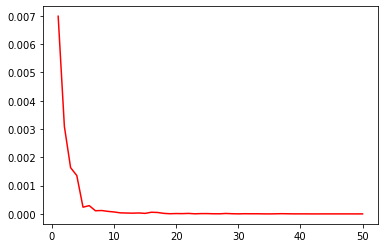

In [20]:
%%time
from sklearn.metrics import mean_squared_error 
# mse = mean_squared_error(A, B)
def ApproShap_shou(ListOfSampling, characteristicF, playerList, counter):
    sha = [0 for i in range(len(playerList))]
    shaOld = [0 for i in range(len(playerList))]
    errors = []
    k = 0
    for ob in ListOfSampling:
        shaNew = [0 for i in range(len(playerList))]
        for i in ob:  # ob is sequence of player id from 0 to N
            pre_i_ob = calculatePre_i(ob, i)  # calculate pre^i(ob)
            x_ob = calculateX(pre_i_ob, i, characteristicF[k])
            sha[i] = sha[i] + x_ob
        shaNew = sha.copy()

        k = k + 1
      #  print("k", k)
        tempError = 0
        if k == 1:
            tempError = mean_squared_error(shaNew, shaOld)
          #  print("first:", tempError)
        else:
            t1 = [x / (k - 1) for x in shaNew]
            t2 = [x / (k - 1) for x in shaOld]
            tempError = mean_squared_error(t1, t2)
           # print("第2次上,t1,t1:,error", t1, t2, tempError)
        errors.append(tempError)
        shaOld = shaNew.copy()
    sha = [x / np.shape(ListOfSampling)[0] for x in sha]
   # print("errors:", errors)
    return sha, errors


playerList = []
for i in range(30):
    playerList.append(i)
counter=50   #sampling size
# characteristicF =[np.zeros(len(playerList))]*counter
            #initial table for characteristic function of coalition in permutation
samplist=[]
start_time = time.time()
characteristicF=[]
P = []
ob=playerList
rep = {}
listOfSampling=permutation(ob,counter)
#print(listOfSampling)
for i in range(counter):
    for j in range(30):
#         if j == 0:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][0])
#             size_zeros = 29
#         else:
#             data_samp_x = getgroup_level(X_,listOfSampling[i][:j])
#             size_zeros =30 - data_samp_x.shape[1]
#         data_samp = np.c_[data_samp_x,np.zeros((569,size_zeros))]
# #         print(np.shape(data_samp))
        X_copy=X_.copy()
        X_copy[:,j+1:30]=np.zeros((569,29-j))

        pr = pr_anomalies(X_copy,y,n_trees=n_trees,desired_TPR=0.8)
        P.append(pr)
       # print("characteristic function:",j,P,X_copy,)
    rep[i] = P
    #print(rep)
RP = np.array(P)
characteristicF = RP.reshape((counter,30))
#     print(i)

sha2,ERR=ApproShap_shou(listOfSampling,characteristicF,playerList,counter)
print(ERR)
plt.plot(np.linspace(1,counter,counter),ERR,'r-')

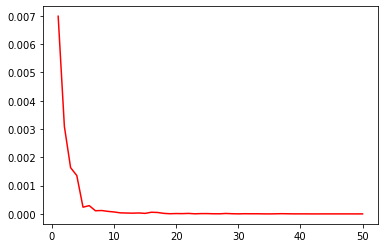

In [21]:
plt.plot(np.linspace(1,counter,counter),ERR,'r-')
plt.savefig('shoulian_80.png')

In [22]:
print(counter)
start_time = time.time()
sha=ApproShap(listOfSampling,characteristicF,playerList,counter)
S_ = sum(abs(np.array(sha)))
Shap_samp = abs(np.array(sha))/S_
stop_time = time.time()
time_cacul = stop_time - start_time
print(f"time {time_cacul:3.2f}s")
print(Shap_samp)



50
time 0.01s
[0.01609148 0.00301878 0.06944098 0.02011105 0.02153598 0.04677713
 0.00396758 0.08614531 0.05769565 0.02333062 0.06579654 0.02222518
 0.03357606 0.06901187 0.01228592 0.05974458 0.01948522 0.00401627
 0.06520751 0.02184303 0.01517532 0.0632407  0.03800343 0.01987181
 0.02578015 0.01637415 0.00230654 0.03773988 0.05421581 0.00598547]


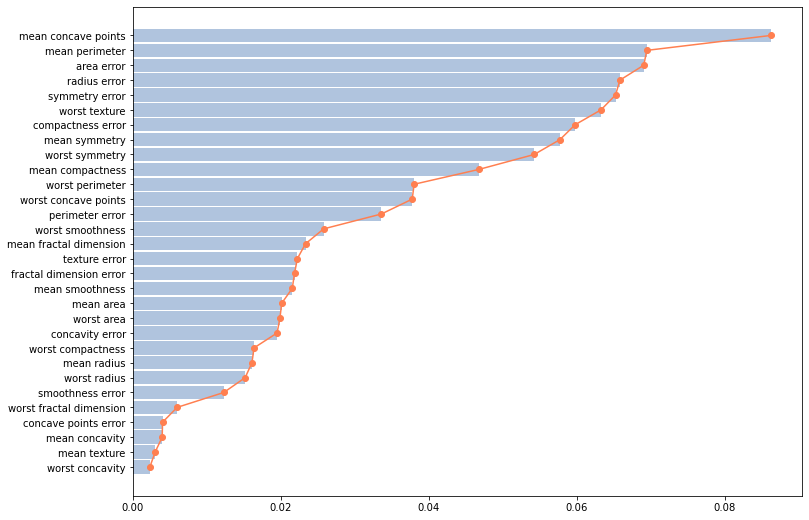

In [23]:
playerlist=['mean radius', 'mean texture', 'mean perimeter','mean area',\
            'mean smoothness', 'mean compactness','mean concavity','mean concave points','mean symmetry','mean fractal dimension','radius error',\
            'texture error','perimeter error','area error','smoothness error','compactness error',\
            'concavity error','concave points error','symmetry error','fractal dimension error','worst radius',\
            'worst texture','worst perimeter','worst area','worst smoothness','worst compactness','worst concavity',\
            'worst concave points','worst symmetry','worst fractal dimension']
Shapley=Shap_samp
df = pd.DataFrame({'eventlist':playerlist, 'shapleys': Shapley})
df=df.sort_values(by=['shapleys'], axis=0, ascending=[True])
#shapleys = [0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404, 0.0027905302007381404]
# plt.bar(shapleys,range(len(eventlist)), color='lightsteelblue')
plt.figure(figsize=(12,9))
plt.bar(x=0, bottom=np.arange(len(df['shapleys'])), height=0.9, width=df['shapleys'], orientation="horizontal",color='lightsteelblue')
plt.plot(df['shapleys'],range(len(df['eventlist'])), marker='o', color='coral')  # coral
plt.yticks(range(len(df['eventlist'])), df['eventlist'])
plt.savefig('Shap_samp_1000.png')